In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import glob

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
# data_type = "train"
# month = "07"
# category = "잔액정보"

# local
root_path = '../../data'

# colab
# root_path = '/content/drive/MyDrive/12조 파이널프로젝트/data'

#drive_folder = f'{root_path}/스탯티즈_Raw_data/'

In [445]:
df1 = pd.read_csv(f'{root_path}/투수_데이터_최종.csv', encoding='utf-8')

- FA 1년차 제외 -> FA 1년차는 FA 되고 난 후 스텟들, 그 전 년들 스텟으로 살펴봐야함
- 해외의 기록 제외함

---

In [449]:
# 1. 복사
df_filtered = df1.copy()

In [451]:
# 2. 'n차' 컬럼 생성: 선수명에 (2차) 포함 + 'FA 1년차' 조건
df_filtered['n차'] = 0
mask = df_filtered['선수명'].str.contains(r'\(2차\)') & (df_filtered['구분'] == 'FA 1년차')
df_filtered.loc[mask, 'n차'] = 1

In [453]:
# 3. 제거할 선수명 명시적으로 제거
제외선수 = [
    '박정진(2차)', '손승락(2차)', '오승환(1차)', 
    '김광현(2차)', '류현진', '강윤구(1차)', '김광현(3차)'
]
df_filtered = df_filtered[~df_filtered['선수명'].isin(제외선수)]

In [455]:
# 4. FA 1년차 중 (2차) 아닌 경우 제거
df_filtered = df_filtered[~((df_filtered['구분'] == 'FA 1년차') & (df_filtered['n차'] == 0))]

In [457]:
# 5. 해외계약자 제외
df_cleaned = df_filtered[
    (~df_filtered['구분'].str.contains('해외'))
].copy()

In [459]:
# 2. 평균 낼 스탯 컬럼
stat_cols = ['종합 WAR', 'ERA', '이닝수', '탈삼진', '볼넷허용', 'FIP', '투구수', '피장타율', '사사구', '원클럽맨여부','WHIP', '나이', '홀드', '세이브', '블론세이브', '블론홀드', '구원 이닝']

In [461]:
# 2-1. 합계 낼 스탯 컬럼
stat_sum = df_cleaned.groupby('선수명').agg({
    '이닝수': 'sum',
    '탈삼진': 'sum',
    '사사구': 'sum',
    '자책점': 'sum'  # ERA* 계산에 필요
}).reset_index()

In [463]:
# 파생 컬럼 계산
stat_sum['ERA*'] = (stat_sum['자책점'] / stat_sum['이닝수']) * 9
stat_sum['K/9'] = (stat_sum['탈삼진']  / stat_sum['이닝수']) * 9
stat_sum['BB/9'] = (stat_sum['사사구'] / stat_sum['이닝수']) * 9

In [465]:
# 3. 선수별 평균 스탯 계산
stat_mean = df_cleaned.groupby('선수명')[stat_cols].mean().reset_index()
stat_mean.columns = ['선수명'] + [f'평균_{col}' for col in stat_cols]

In [467]:
# 4-A. '투' 컬럼 전처리: 우 → 우투, 좌 → 좌투
df_cleaned['투'] = df_cleaned['투'].apply(
    lambda x: '우투' if '우' in str(x) else ('좌투' if '좌' in str(x) else x)
)

In [469]:
# 4. 선수별 포지션 정보 추가 (대표값 추출)
pos_info = df_cleaned.groupby('선수명')[['투', '세부 포지션']].agg(lambda x: x.mode().iloc[0]).reset_index()

In [471]:
# 5. 계약 총액 + 계약 연수 정보
fa_contract = df1[df1['FA 계약 연수'] > 0][['선수명', 'FA 계약 총액', 'FA 계약 연수']].drop_duplicates('선수명')
fa_contract['연평균 계약 금액'] = fa_contract['FA 계약 총액'] / fa_contract['FA 계약 연수']

In [473]:
# === 최종 병합 (평균 + 합계 파생컬럼 + 포지션 + 계약 정보) ===
merged = stat_mean.merge(stat_sum[['선수명', 'ERA*', 'K/9', 'BB/9']], on='선수명') \
                  .merge(pos_info, on='선수명') \
                  .merge(fa_contract, on='선수명')

In [475]:
# 7. 원핫 인코딩
df_encoded = pd.get_dummies(merged, columns=['투', '세부 포지션'])

In [477]:
# 8. 상관관계 분석 대상 컬럼 선택
columns_for_corr = [col for col in df_encoded.columns if col.startswith('평균_') or col.startswith('투_') or col.startswith('세부 포지션_')]
columns_for_corr.append('연평균 계약 금액')

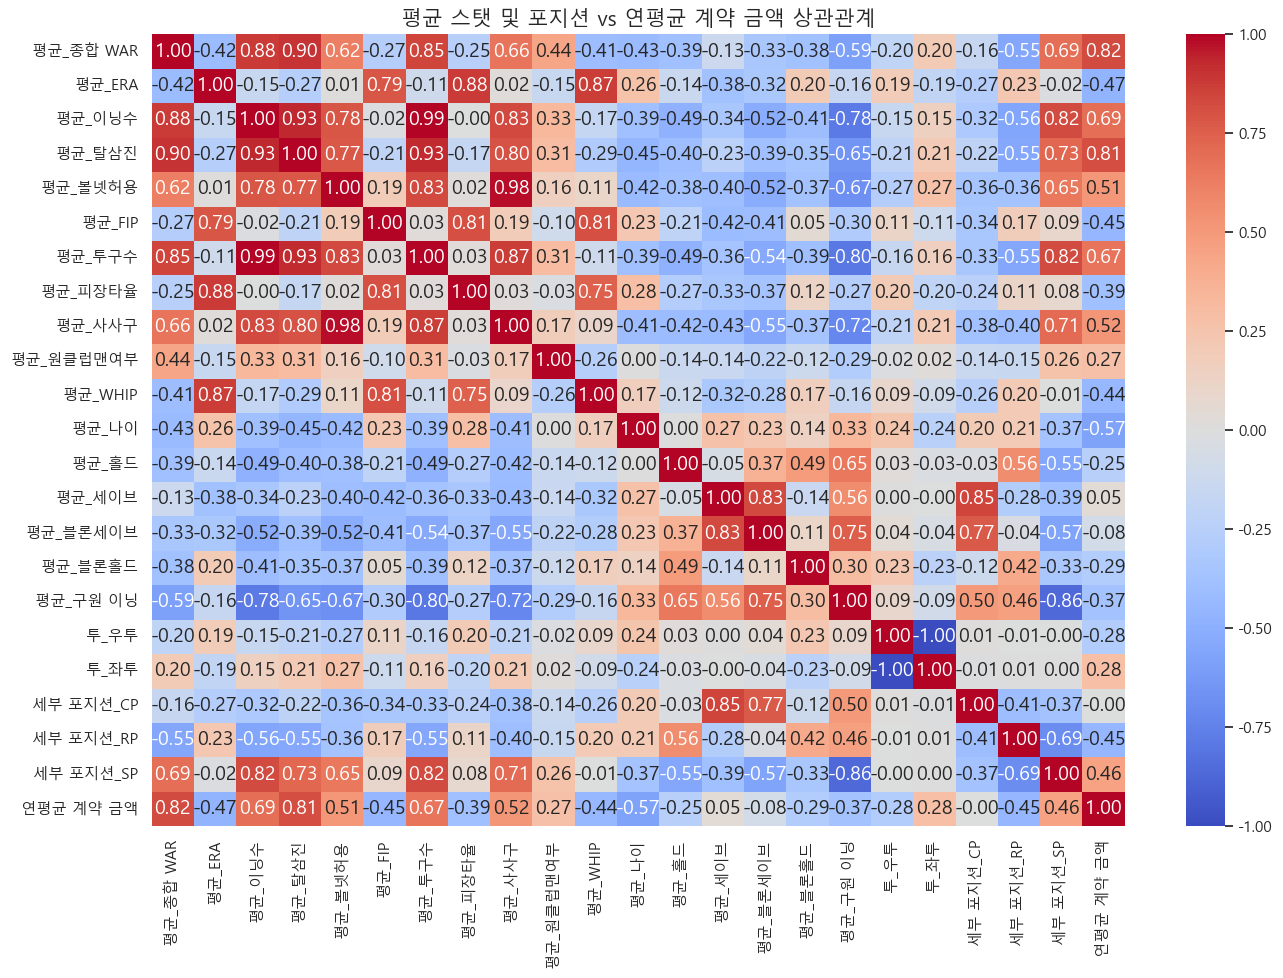

In [479]:
# 9. 상관관계 분석 및 시각화 (전체 선수)
corr_df = df_encoded[columns_for_corr].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("평균 스탯 및 포지션 vs 연평균 계약 금액 상관관계", fontsize=15)
plt.tight_layout()
plt.show()

In [401]:
# 구원투수만 필터링
df_reliever = df_encoded[df_encoded['평균_구원 이닝'] > 28]

In [403]:
# columns_for_corr에 있는 컬럼이 모두 존재하도록 보정
for col in columns_for_corr:
    if col not in df_reliever.columns:
        df_reliever[col] = 0

In [405]:
# 상관관계 분석
corr_df = df_reliever[columns_for_corr].corr()

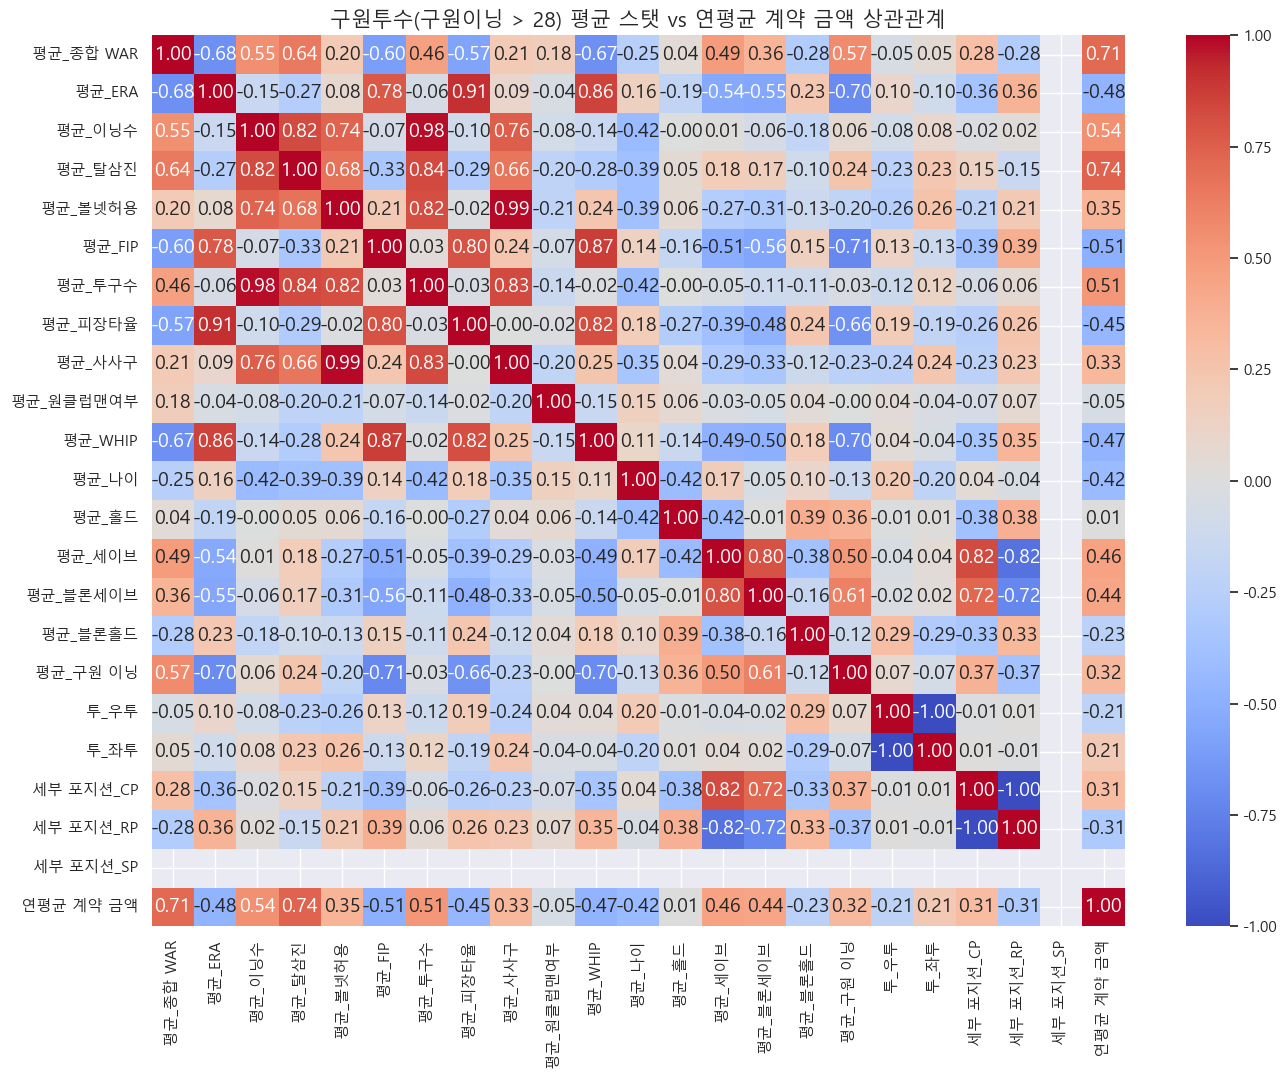

In [407]:
# 시각화
plt.figure(figsize=(14, 11))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("구원투수(구원이닝 > 28) 평균 스탯 vs 연평균 계약 금액 상관관계", fontsize=15)
plt.tight_layout()
plt.show()

---

## 스텟들 vs FA_연평균계약금  (FA 계약 총액 / FA 계약 연수)

- 함수 사용

In [24]:
# 산점도
def scatter_with_size(df, x_col, y_col='연평균 계약 금액'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        size=x_col,
        hue=x_col,
        palette='summer',
        sizes=(30, 200)
    )
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
# 막대그래프
def binned_barplot_custom(df, x_col, y_col='연평균 계약 금액', bins=None, labels=None):
    df = df.copy()

    if bins is None or labels is None:
        raise ValueError("bins와 labels는 반드시 지정해야 합니다.")
    
    df['구간'] = pd.cut(df[x_col], bins=bins, labels=labels, right=False)

    grouped = df.groupby('구간', observed=False)[y_col].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped, x='구간', y=y_col, hue='구간', palette='summer')
    plt.title(f'{x_col} 구간별 {y_col} 평균')
    plt.xlabel(f'{x_col} 구간')
    plt.ylabel(f'{y_col} (원)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

---

### 1. 이닝수 vs FA_연평균계약금 (선발이면 이닝수가 많지 않나 ..?)

- 산점도

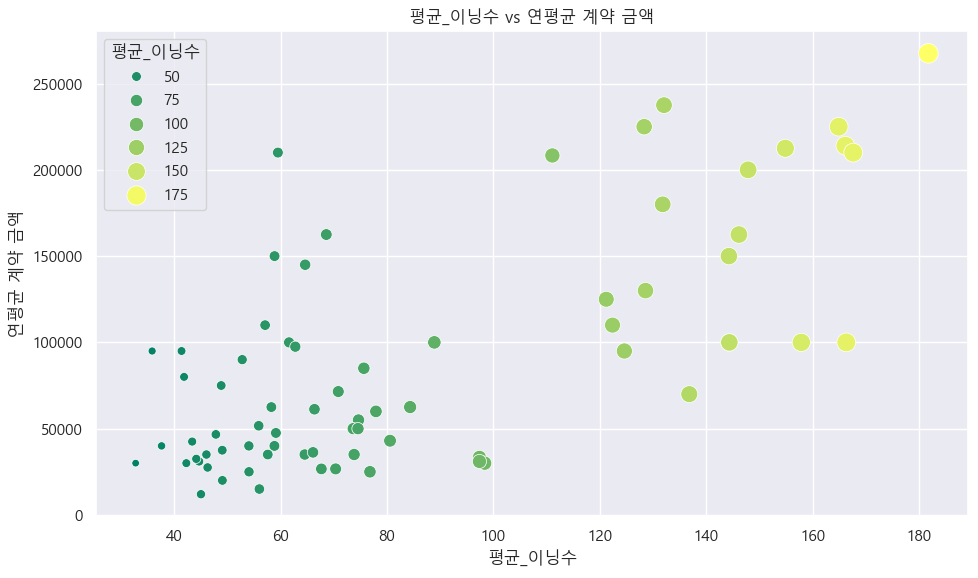

In [29]:
scatter_with_size(merged, '평균_이닝수')

- 막대

In [31]:
merged['평균_이닝수'].min()

32.775

In [32]:
merged['평균_이닝수'].max()

181.71999999999997

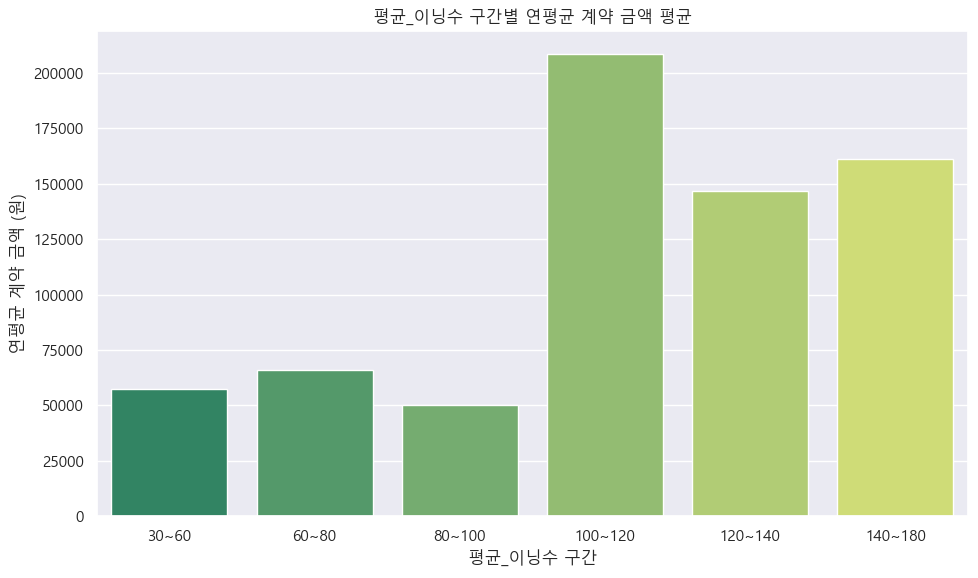

In [33]:
binned_barplot_custom(
    merged,
    x_col='평균_이닝수',
    bins=[30, 60, 80, 100, 120, 140, 180],
    labels=['30~60', '60~80', '80~100', '100~120', '120~140', '140~180']
)

In [34]:
# 상관계수 계산
correlation = merged[['평균_이닝수', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 이닝수와 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 이닝수와 계약 총액의 상관계수: 0.692


---

### 2. ERA vs FA_연평균계약금

- 산점도

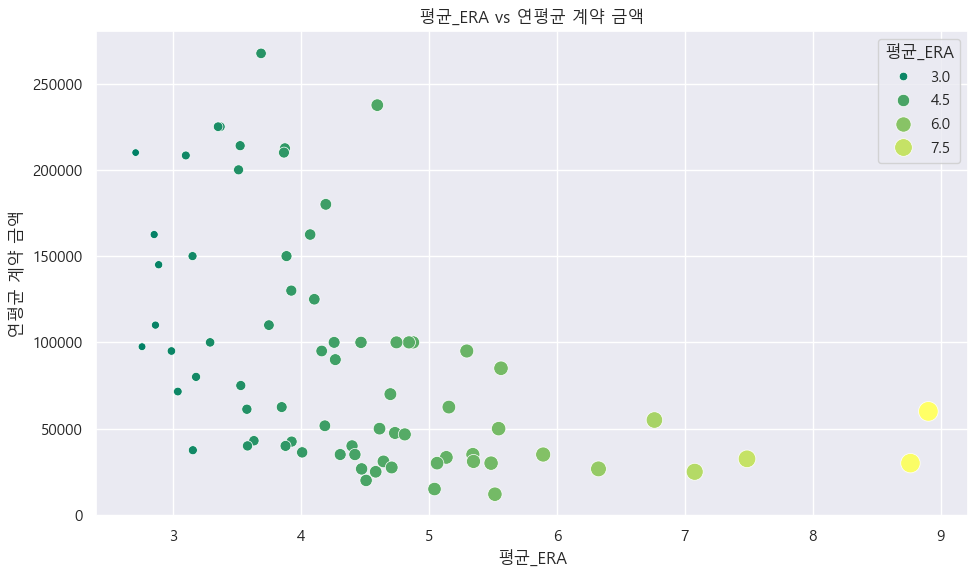

In [38]:
scatter_with_size(merged, '평균_ERA')

- 막대

In [40]:
merged['평균_ERA'].min()

2.705

In [41]:
merged['평균_ERA'].max()

8.905

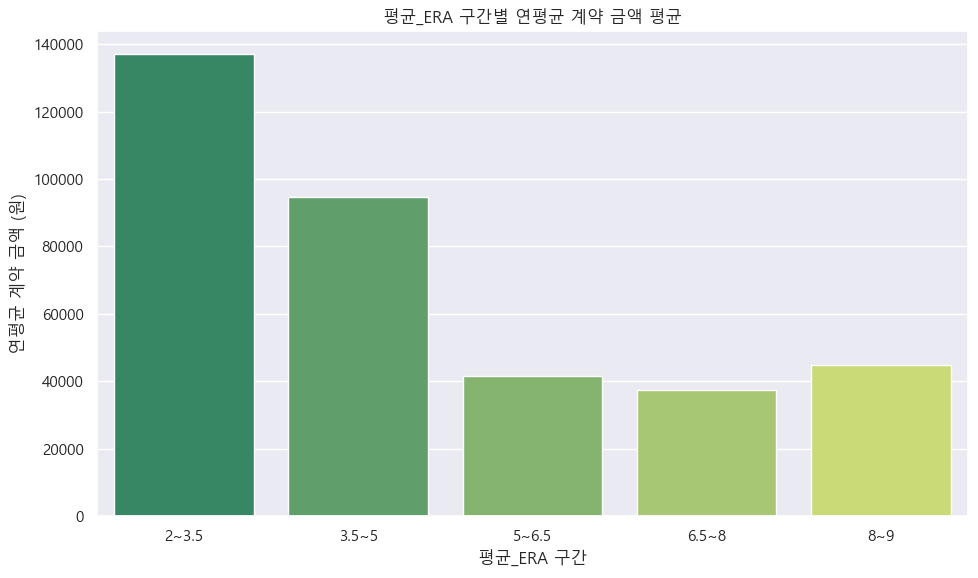

In [42]:
binned_barplot_custom(
    merged,
    x_col='평균_ERA',
    bins = [2, 3.5, 5, 6.5, 8, 9],
    labels = ['2~3.5', '3.5~5', '5~6.5', '6.5~8', '8~9']
)

In [43]:
# 상관계수 계산
correlation = merged[['평균_ERA', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 ERA와 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 ERA와 계약 총액의 상관계수: -0.471


---

### 3. 종합 WAR vs FA_연평균계약금

- 산점도

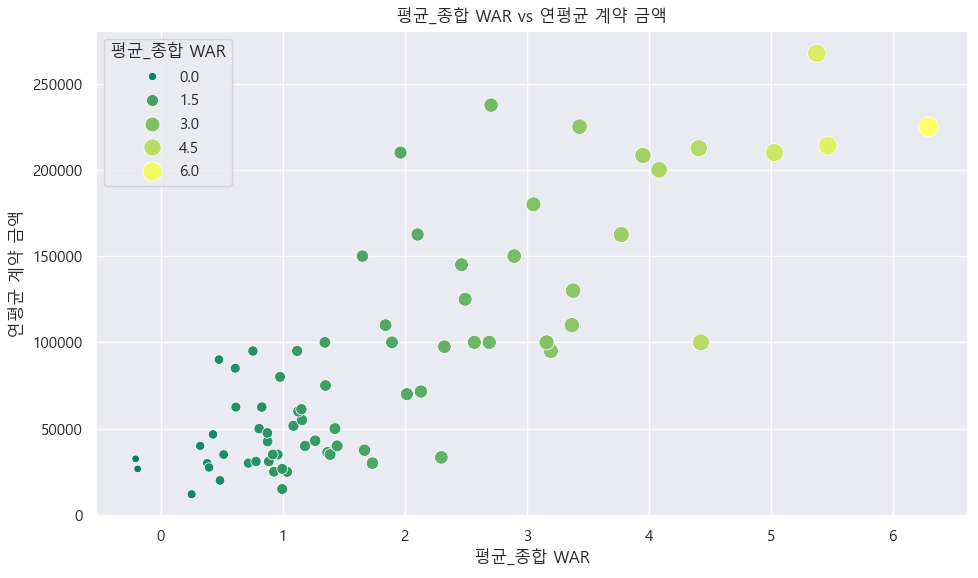

In [47]:
scatter_with_size(merged, '평균_종합 WAR')

- 막대

In [49]:
merged['평균_종합 WAR'].min()

-0.20666666666666667

In [50]:
merged['평균_종합 WAR'].max()

6.2925

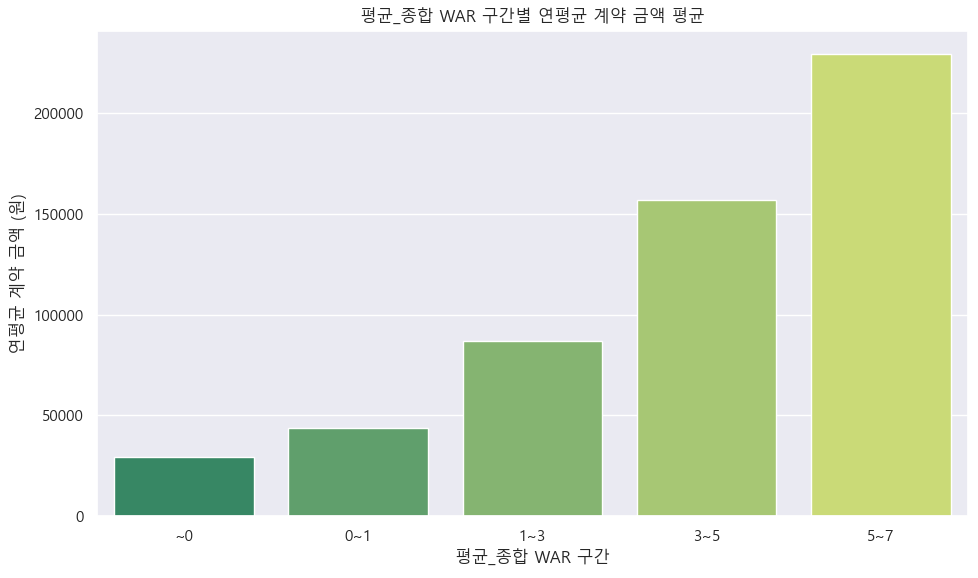

In [51]:
binned_barplot_custom(
    merged,
    x_col='평균_종합 WAR',
    bins = [-3, 0, 1, 3, 5, 7],
    labels = ['~0', '0~1', '1~3', '3~5', '5~7']
)

In [52]:
# 상관계수 계산
correlation = merged[['평균_종합 WAR', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 종합 WAR과 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 종합 WAR과 계약 총액의 상관계수: 0.824


---

### 4. 탈삼진 vs FA_연평균계약금 (탈삼진 기준 변경 필요할지도)

- 산점도

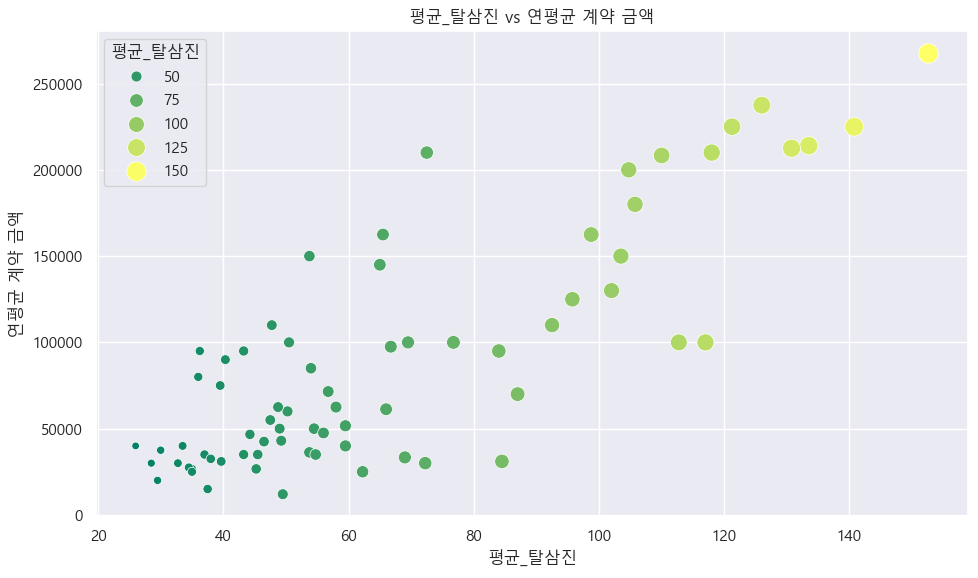

In [56]:
scatter_with_size(merged, '평균_탈삼진')

- 막대

In [58]:
merged['평균_탈삼진'].min()

26.0

In [59]:
merged['평균_탈삼진'].max()

152.6

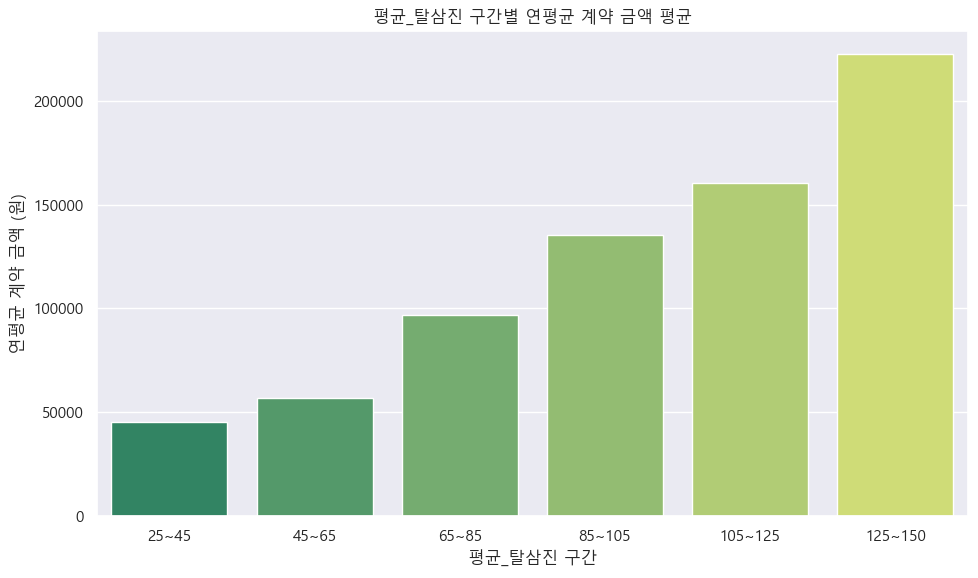

In [60]:
binned_barplot_custom(
    merged,
    x_col='평균_탈삼진',
    bins = [25, 45, 65, 85, 105, 125, 150],
    labels = ['25~45','45~65','65~85','85~105','105~125','125~150']
)

In [61]:
# 상관계수 계산
correlation = merged[['평균_탈삼진', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 탈삼진과 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 탈삼진과 계약 총액의 상관계수: 0.813


---

### 5. FIP vs FA_연평균계약금

- 산점도

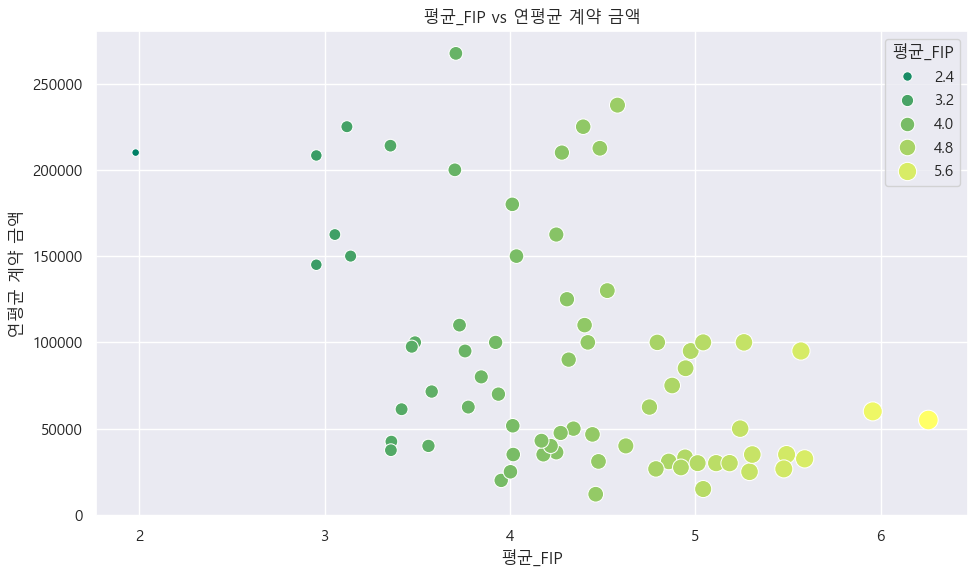

In [65]:
scatter_with_size(merged, '평균_FIP')

- 막대

In [67]:
merged['평균_FIP'].min()

1.98

In [68]:
merged['평균_FIP'].max()

6.2575

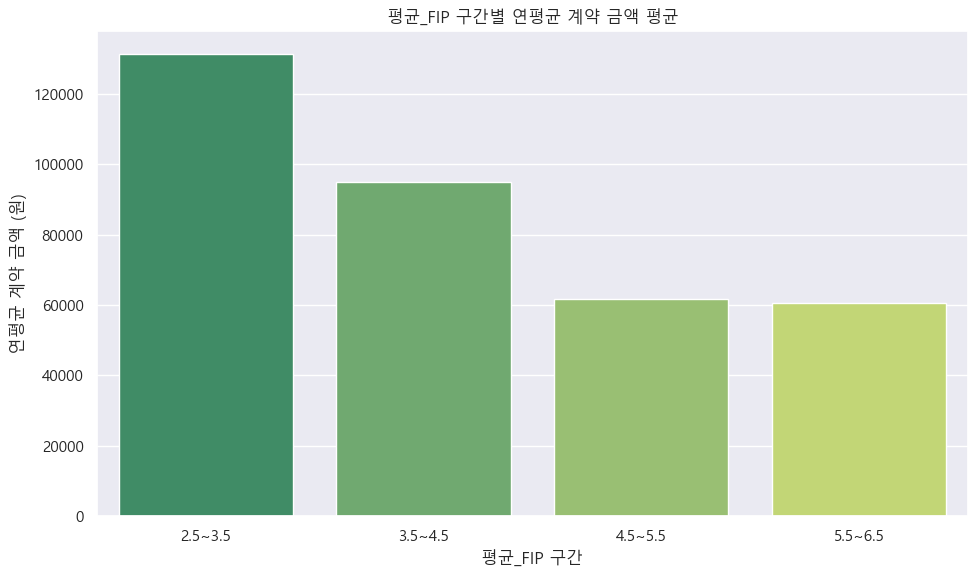

In [69]:
binned_barplot_custom(
    merged,
    x_col='평균_FIP',
    bins = [2.5, 3.5, 4.5, 5.5, 6.5],
    labels = ['2.5~3.5','3.5~4.5','4.5~5.5','5.5~6.5']
)

In [70]:
# 상관계수 계산
correlation = merged[['평균_FIP', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 FIP와 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 FIP와 계약 총액의 상관계수: -0.452


---

### 6. 피장타율 vs FA_연평균계약금

- 산점도

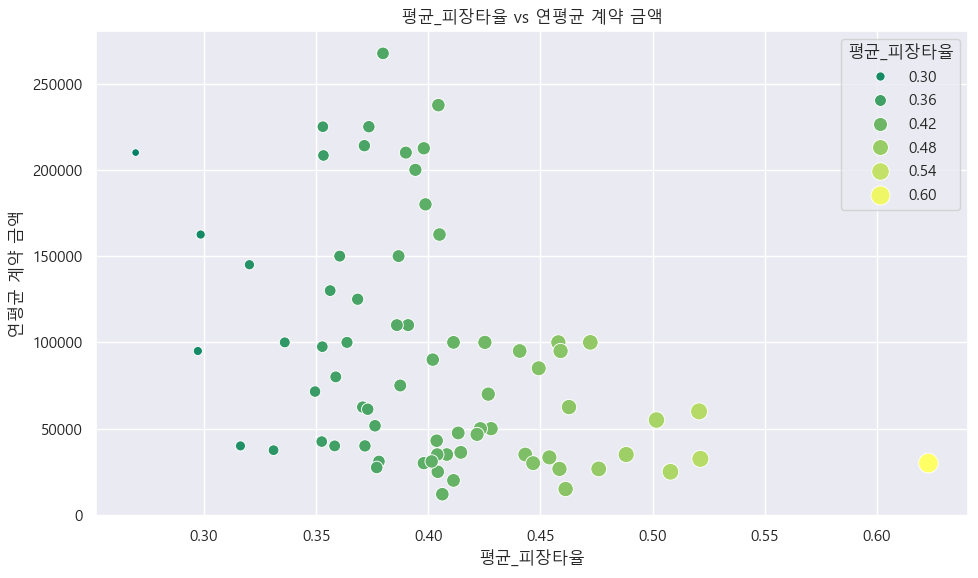

In [74]:
scatter_with_size(merged, '평균_피장타율')

- 막대

In [76]:
merged['평균_피장타율'].min()

0.26949999999999996

In [77]:
merged['평균_피장타율'].max()

0.623

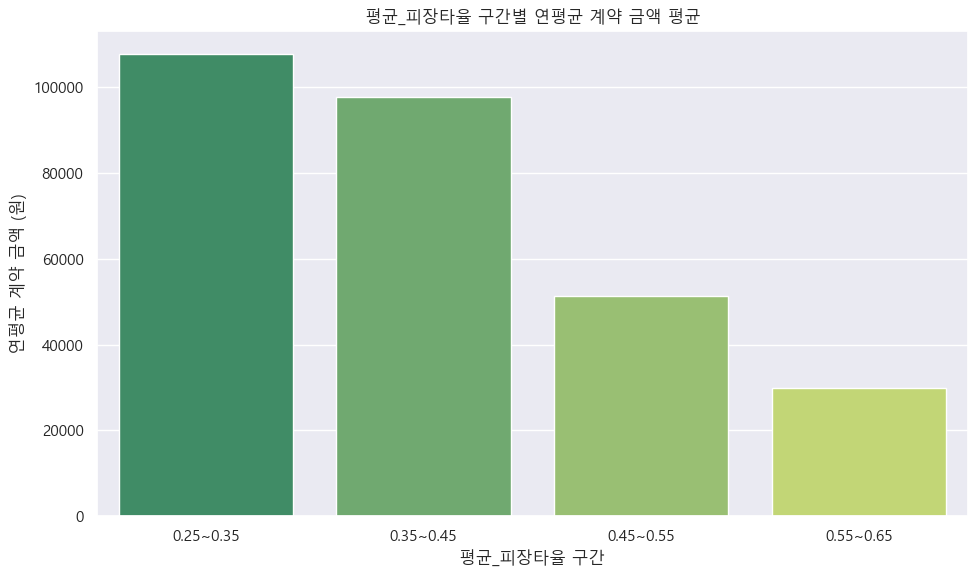

In [78]:
binned_barplot_custom(
    merged,
    x_col='평균_피장타율',
    bins = [0.25, 0.35, 0.45, 0.55, 0.65],
    labels = ['0.25~0.35','0.35~0.45','0.45~0.55','0.55~0.65']
)

In [79]:
# 상관계수 계산
correlation = merged[['평균_피장타율', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 피장타율와 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 피장타율와 계약 총액의 상관계수: -0.390


---

### 7. 볼넷허용 vs FA_연평균계약금 (의미X)

- 산점도

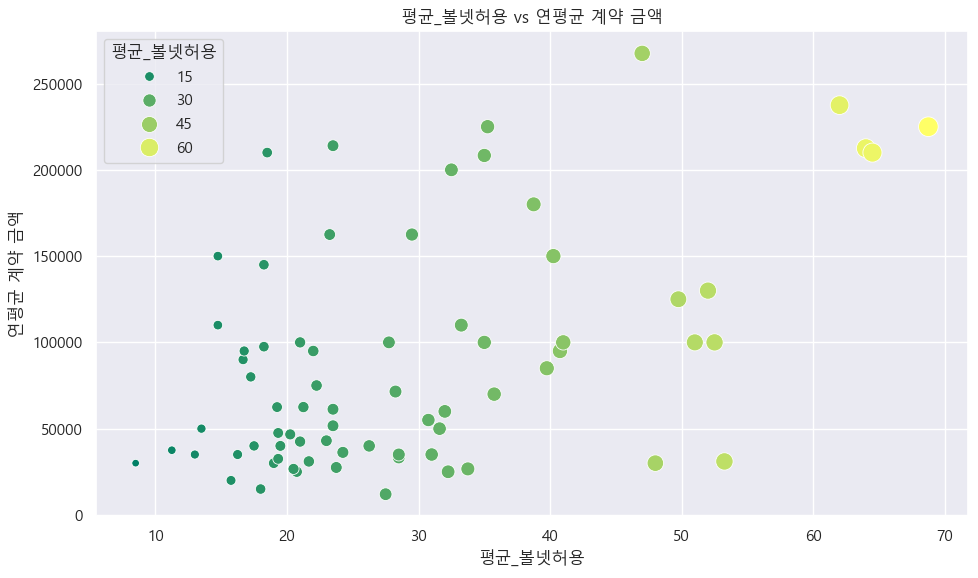

In [83]:
scatter_with_size(merged, '평균_볼넷허용')

In [84]:
merged['평균_볼넷허용'].min()

8.5

In [85]:
merged['평균_볼넷허용'].max()

68.75

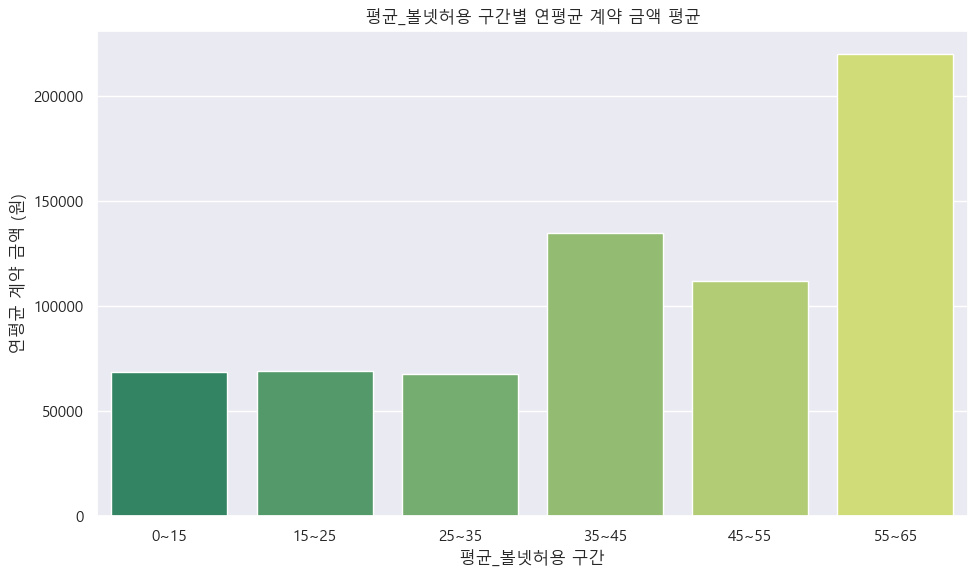

In [86]:
binned_barplot_custom(
    merged,
    x_col='평균_볼넷허용',
    bins = [0, 15, 25, 35, 45, 55, 65],
    labels = ['0~15','15~25','25~35','35~45','45~55','55~65']
)

In [87]:
# 상관계수 계산
correlation = merged[['평균_볼넷허용', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 볼넷허용과 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 볼넷허용과 계약 총액의 상관계수: 0.510


---

### 8. 투구수 vs FA_연평균계약금 (당연히 선발이 투구수 많지 않나..)

- 산점도

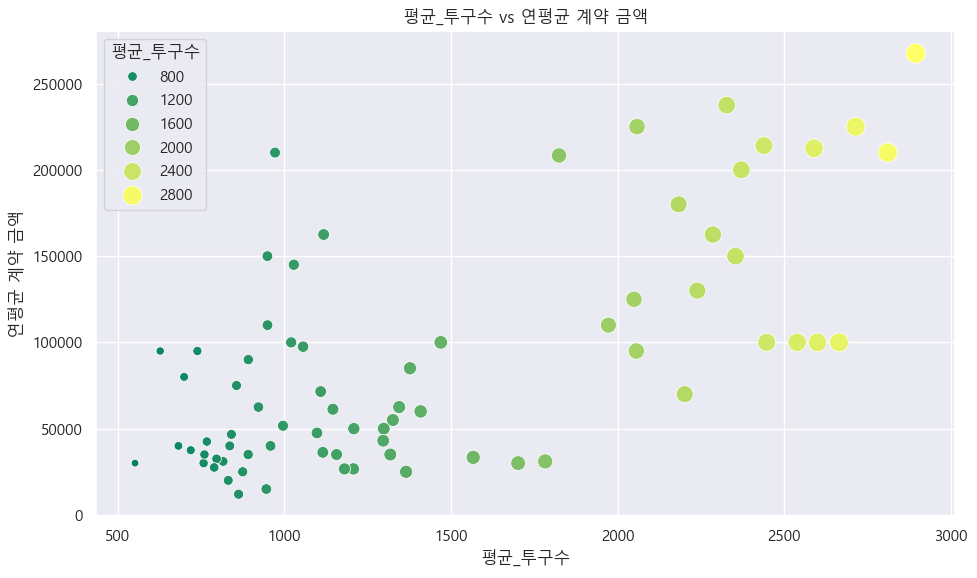

In [91]:
scatter_with_size(merged, '평균_투구수')

- 막대

In [93]:
merged['평균_투구수'].min()

552.0

In [94]:
merged['평균_투구수'].max()

2894.6

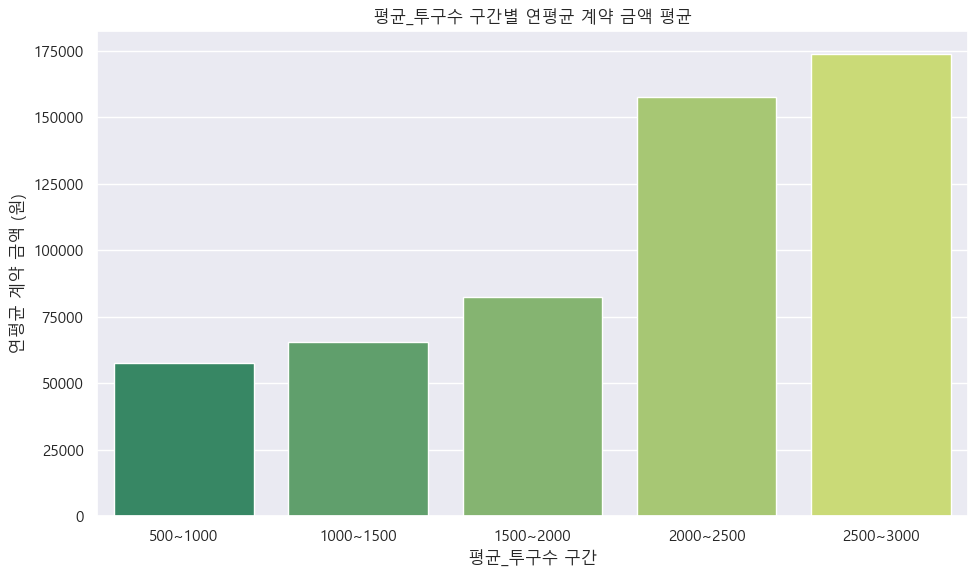

In [95]:
binned_barplot_custom(
    merged,
    x_col='평균_투구수',
    bins = [500, 1000, 1500, 2000, 2500, 3000],
    labels = ['500~1000', '1000~1500', '1500~2000', '2000~2500', '2500~3000']
)

In [96]:
# 상관계수 계산
correlation = merged[['평균_투구수', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 투구수와 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 투구수와 계약 총액의 상관계수: 0.671


---

### 9. 사사구 vs FA_연평균계약금 (별 의미 X)

- 산점도

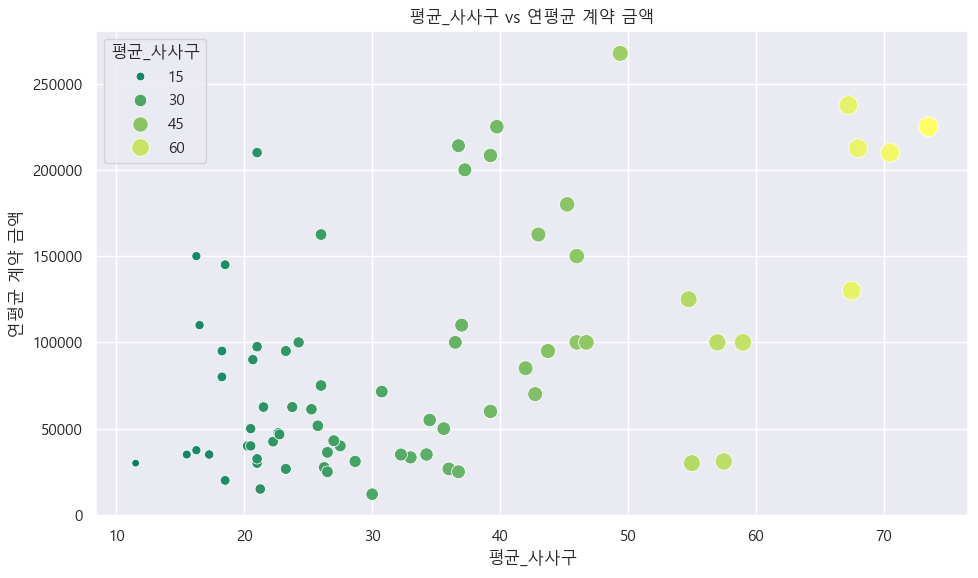

In [100]:
scatter_with_size(merged, '평균_사사구')

- 막대

In [102]:
merged['평균_사사구'].min()

11.5

In [103]:
merged['평균_사사구'].max()

73.5

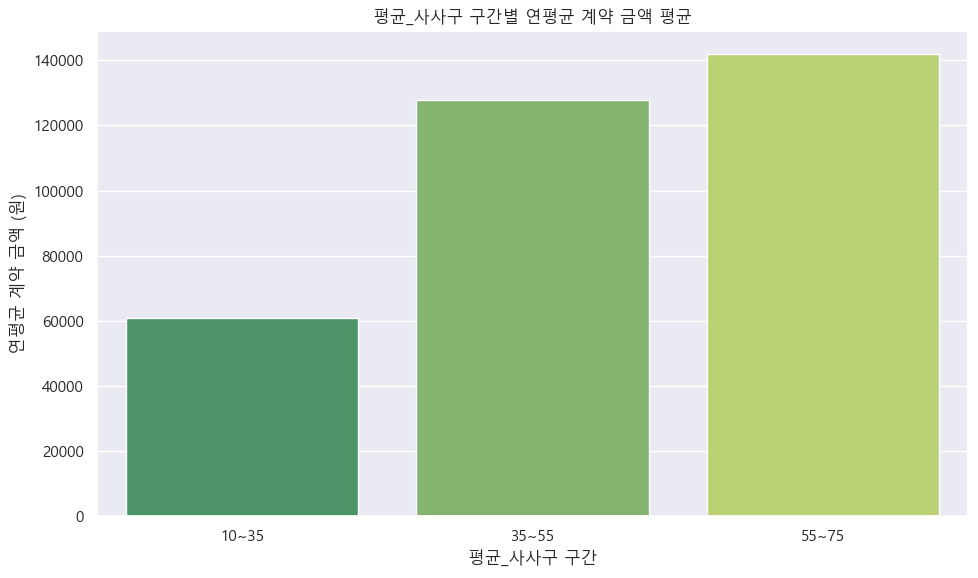

In [104]:
binned_barplot_custom(
    merged,
    x_col='평균_사사구',
    bins = [10, 35, 55, 75],
    labels = ['10~35', '35~55', '55~75']
)

In [105]:
# 상관계수 계산
correlation = merged[['평균_사사구', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 평균 사사구와 계약 총액의 상관계수: {correlation:.3f}')

📌 평균 사사구와 계약 총액의 상관계수: 0.518


---

### 10. 투 vs FA_연평균계약금

- 막대

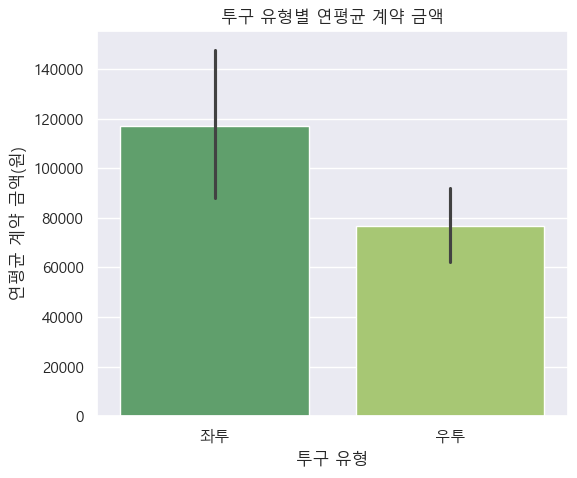

In [109]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged, x='투', y='연평균 계약 금액', hue='투', palette='summer')
plt.title('투구 유형별 연평균 계약 금액')
plt.xlabel('투구 유형')
plt.ylabel('연평균 계약 금액(원)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [110]:
# 상관계수는
# 히트맵에 있음

---

### 11. 세부 포지션 vs FA_연평균계약금

- 막대

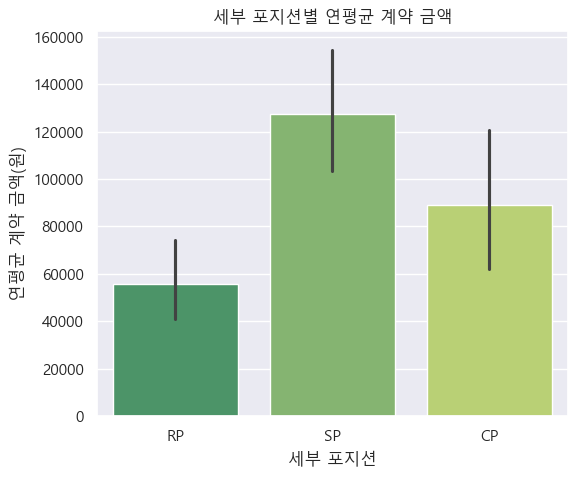

In [114]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged, x='세부 포지션', y='연평균 계약 금액', hue='세부 포지션', palette='summer')
plt.title('세부 포지션별 연평균 계약 금액')
plt.xlabel('세부 포지션')
plt.ylabel('연평균 계약 금액(원)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [115]:
# 상관계수는
# 히트맵에 있음

---

### 12. 원클럽맨여부 vs FA_연평균계약금

- 막대

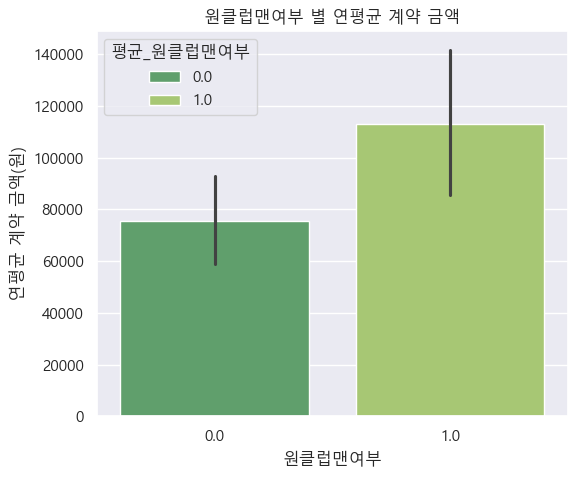

In [119]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged, x='평균_원클럽맨여부', y='연평균 계약 금액', hue='평균_원클럽맨여부', palette='summer')
plt.title('원클럽맨여부 별 연평균 계약 금액')
plt.xlabel('원클럽맨여부')
plt.ylabel('연평균 계약 금액(원)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [120]:
# 상관계수 계산
correlation = merged[['평균_원클럽맨여부', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 원클럽맨여부와 계약 총액의 상관계수: {correlation:.3f}')

📌 원클럽맨여부와 계약 총액의 상관계수: 0.274


---

### 추가
- 국가대표 경력 여부
- 완투, 완봉
- 게임, 이닝당 투구수 --> 일단 제외
- 파크팩터 (해외 제외)
- 히트맵은 맨 위 코드를 통해 다시 봐야함

---

#### 국대출전여부

In [125]:
# 선수별 국가대표 평균 계산
national_team = df1.groupby('선수명')['국대출전횟수'].mean().reset_index()

# 조건에 따라 1 또는 0으로 변환
national_team['국대출전여부'] = national_team['국대출전횟수'].apply(lambda x: 1 if x > 0 else 0)

# 필요한 컬럼만 정리
national_team = national_team[['선수명', '국대출전여부']]

In [126]:
merged = merged.merge(national_team, on='선수명', how='left')

#### 완투, 완봉 (여부)

In [128]:
# 선수별 완투 / 완봉 합계
complete_stats = df1.groupby('선수명')[['완투', '완봉']].sum().reset_index()

# 경험 여부 컬럼 추가
complete_stats['완투_여부'] = complete_stats['완투'].apply(lambda x: 1 if x > 0 else 0)
complete_stats['완봉_여부'] = complete_stats['완봉'].apply(lambda x: 1 if x > 0 else 0)

# 필요 컬럼만 선택
complete_flags = complete_stats[['선수명', '완투_여부', '완봉_여부']]

In [129]:
merged = merged.merge(complete_flags, on='선수명', how='left')

#### 파크팩터

In [131]:
# 선수별 홈런 파크팩터 평균 (df_cleaned에서)
hr_park = df_cleaned.groupby('선수명')['홈런파크팩터'].mean().reset_index()

In [132]:
merged = merged.merge(hr_park, on='선수명', how='left')

---

### 13. 국대출전여부 vs FA_연평균계약금

- 막대

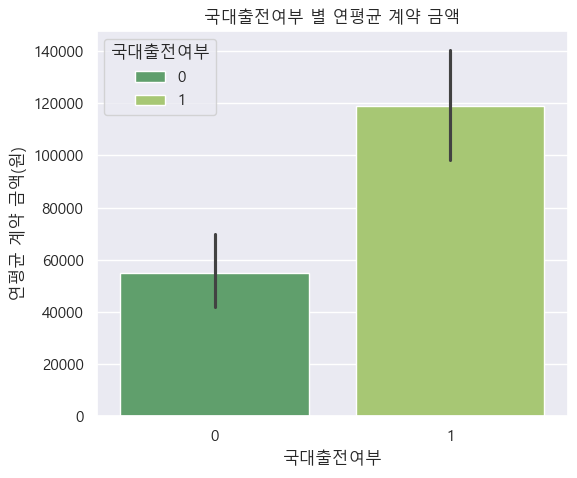

In [136]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged, x='국대출전여부', y='연평균 계약 금액', hue='국대출전여부', palette='summer')
plt.title('국대출전여부 별 연평균 계약 금액')
plt.xlabel('국대출전여부')
plt.ylabel('연평균 계약 금액(원)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [137]:
# 상관계수 계산
correlation = merged[['국대출전여부', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 국대출전여부와 계약 총액의 상관계수: {correlation:.3f}')

📌 국대출전여부와 계약 총액의 상관계수: 0.484


---

### 14. 완투/완봉 vs FA_연평균계약금

- 막대

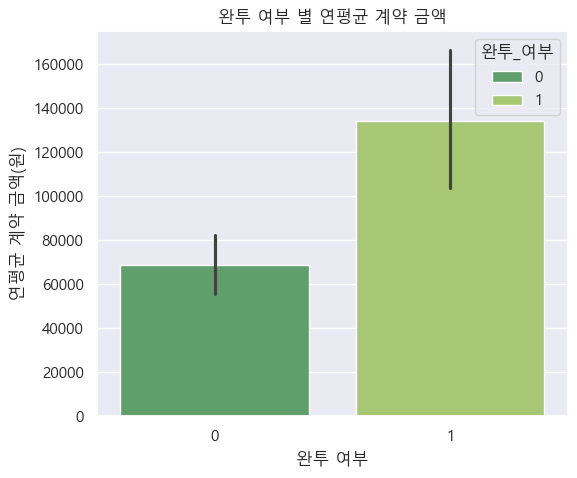

In [141]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged, x='완투_여부', y='연평균 계약 금액', hue='완투_여부', palette='summer')
plt.title('완투 여부 별 연평균 계약 금액')
plt.xlabel('완투 여부')
plt.ylabel('연평균 계약 금액(원)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

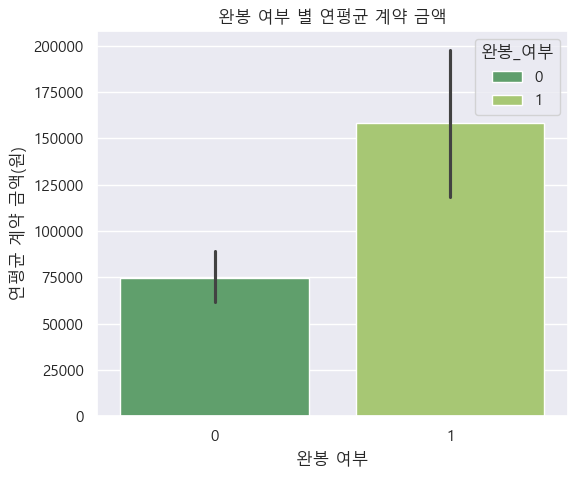

In [142]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged, x='완봉_여부', y='연평균 계약 금액', hue='완봉_여부', palette='summer')
plt.title('완봉 여부 별 연평균 계약 금액')
plt.xlabel('완봉 여부')
plt.ylabel('연평균 계약 금액(원)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [143]:
# 상관계수 계산
correlation = merged[['완투_여부', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 완투_여부와 계약 총액의 상관계수: {correlation:.3f}')

📌 완투_여부와 계약 총액의 상관계수: 0.463


In [144]:
# 상관계수 계산
correlation = merged[['완봉_여부', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 완봉_여부와 계약 총액의 상관계수: {correlation:.3f}')

📌 완봉_여부와 계약 총액의 상관계수: 0.487


---

### 15. 홈런파크팩터 vs FA_연평균계약금

- 산점도

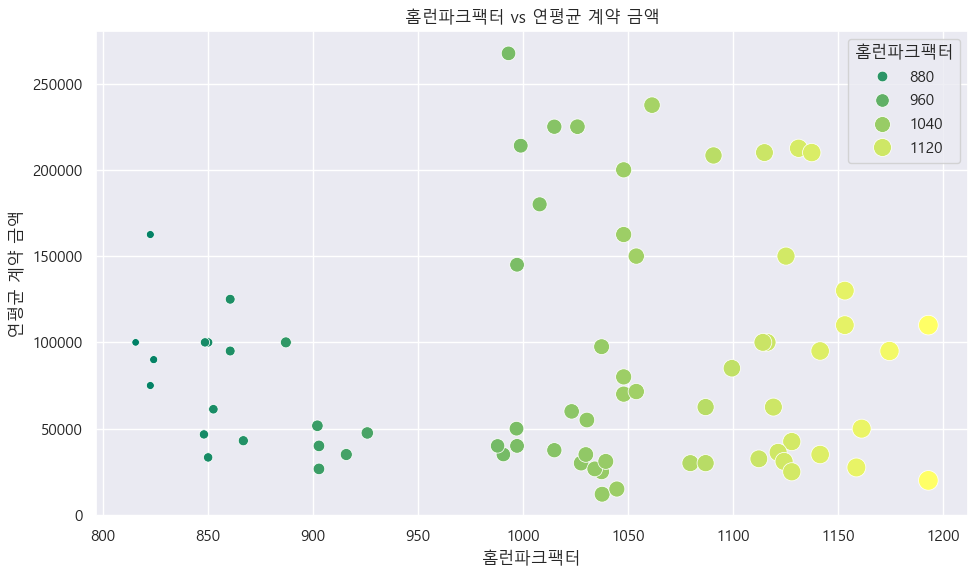

In [148]:
scatter_with_size(merged, '홈런파크팩터')

- 막대

In [150]:
merged['홈런파크팩터'].min()

815.75

In [151]:
merged['홈런파크팩터'].max()

1193.0

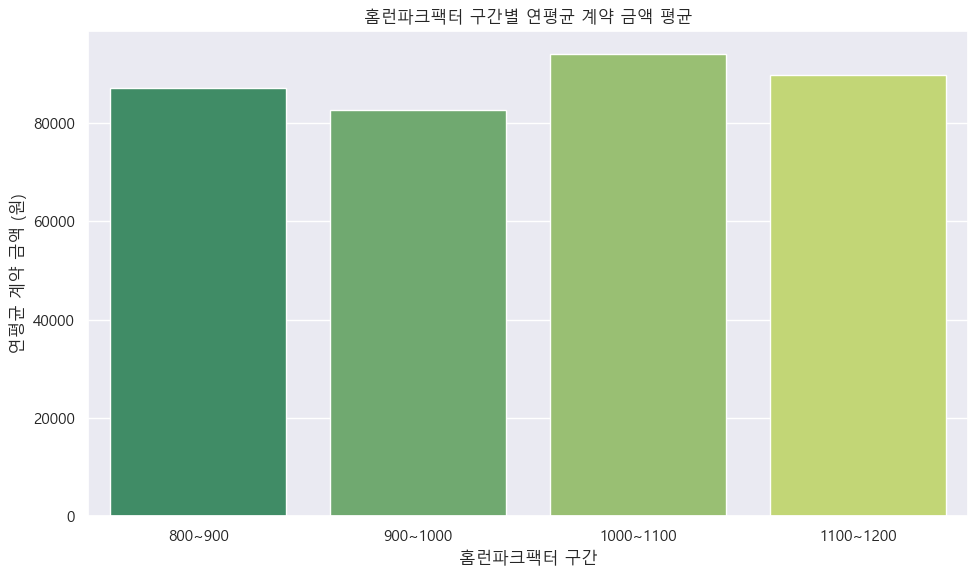

In [152]:
binned_barplot_custom(
    merged,
    x_col='홈런파크팩터',
    bins = [800, 900, 1000, 1100, 1200],
    labels = ['800~900', '900~1000', '1000~1100', '1100~1200']
)

In [153]:
# 상관계수 계산
correlation = merged[['홈런파크팩터', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 홈런파크팩터와 계약 총액의 상관계수: {correlation:.3f}')

📌 홈런파크팩터와 계약 총액의 상관계수: 0.052


---

## 16. WHIP

- 산점도

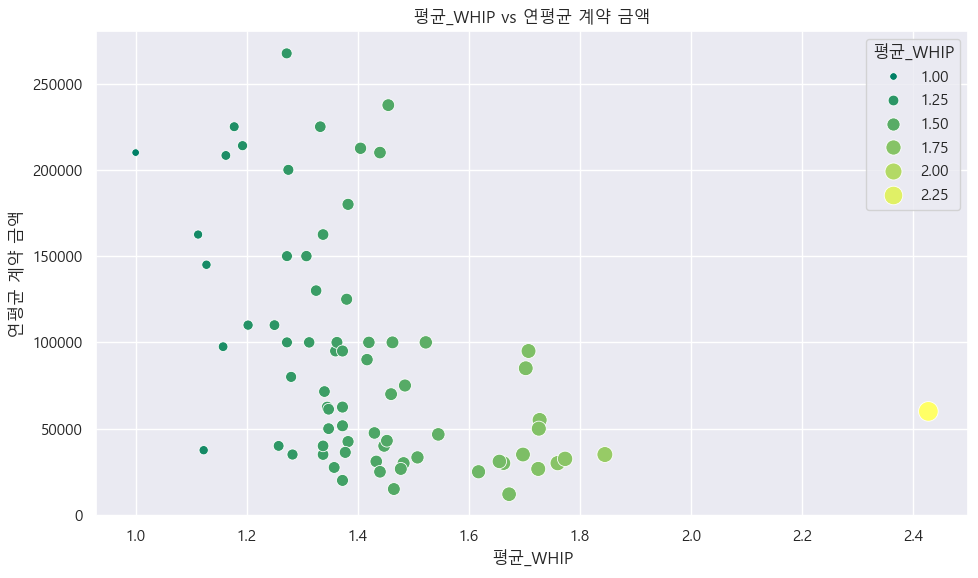

In [157]:
scatter_with_size(merged, '평균_WHIP')

In [158]:
merged['평균_WHIP'].min()

1.0

In [159]:
merged['평균_WHIP'].max()

2.4275

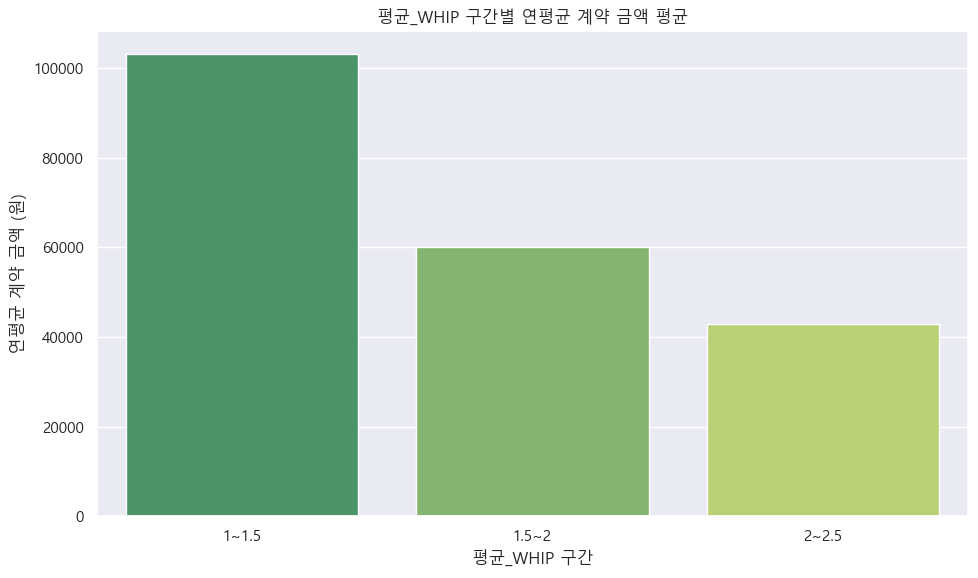

In [160]:
binned_barplot_custom(
    merged,
    x_col='평균_WHIP',
    bins = [1, 1.5, 1.6, 2.5],
    labels = ['1~1.5', '1.5~2', '2~2.5']
)

In [161]:
# 상관계수 계산
correlation = merged[['평균_WHIP', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 WHIP와 계약 총액의 상관계수: {correlation:.3f}')

📌 WHIP와 계약 총액의 상관계수: -0.443


---

## 추가1. ERA*

- 산점도

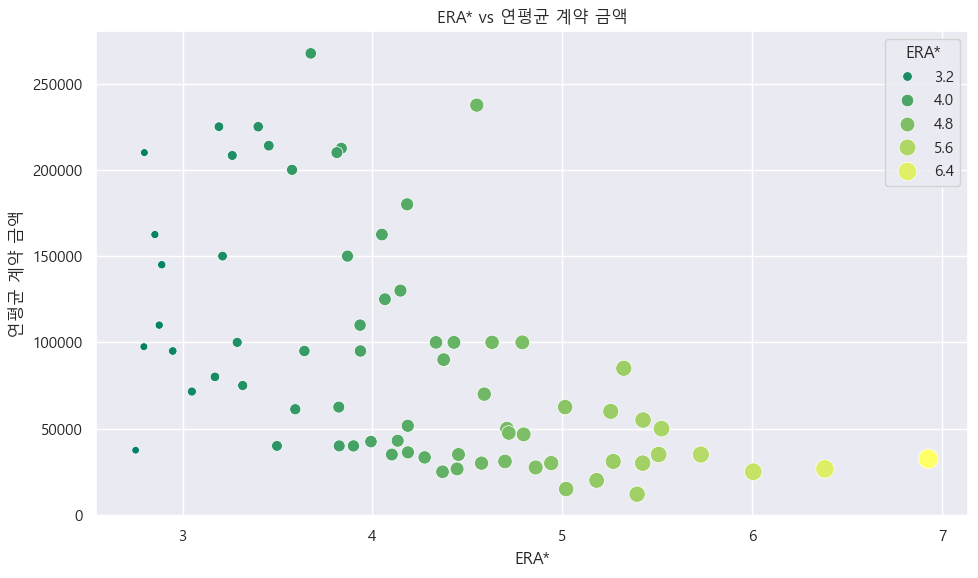

In [200]:
scatter_with_size(merged, 'ERA*')

- 막대

In [191]:
merged['ERA*'].min()

2.7522935779816518

In [193]:
merged['ERA*'].max()

6.928301886792453

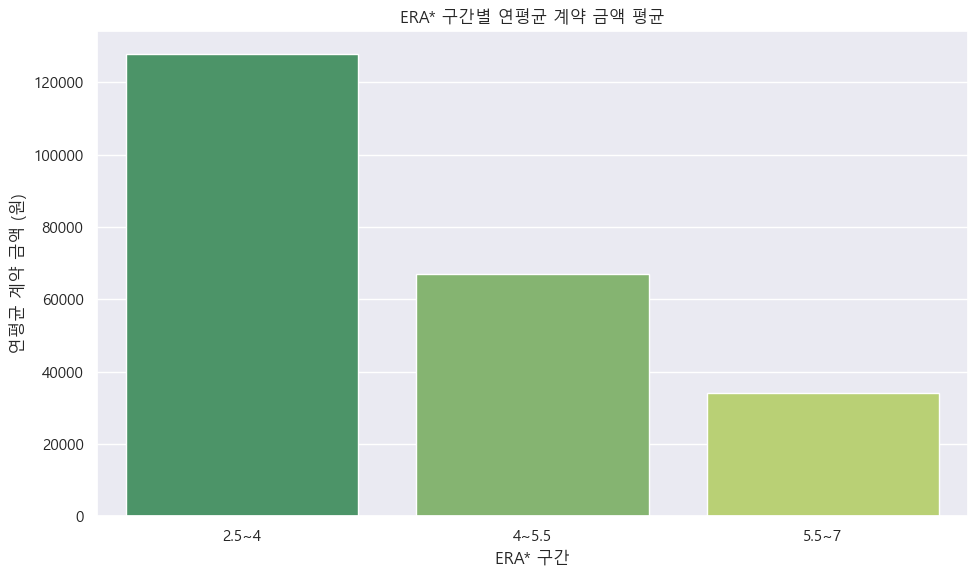

In [207]:
binned_barplot_custom(
    merged,
    x_col='ERA*',
    bins = [2.5, 4, 5.5, 7],
    labels = ['2.5~4', '4~5.5', '5.5~7']
)

In [220]:
# 상관계수 계산
correlation = merged[['ERA*', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 ERA*과 계약 총액의 상관계수: {correlation:.3f}')

📌 ERA*과 계약 총액의 상관계수: -0.521


## 추가2. K/9

- 산점도

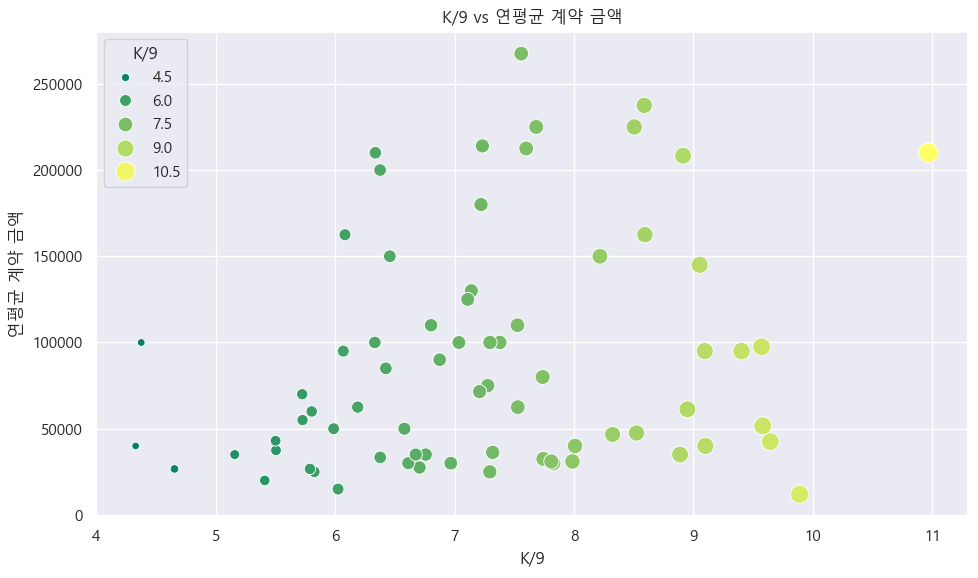

In [213]:
scatter_with_size(merged, 'K/9')

- 막대

In [216]:
merged['K/9'].min()

4.329324699352451

In [218]:
merged['K/9'].max()

10.966386554621847

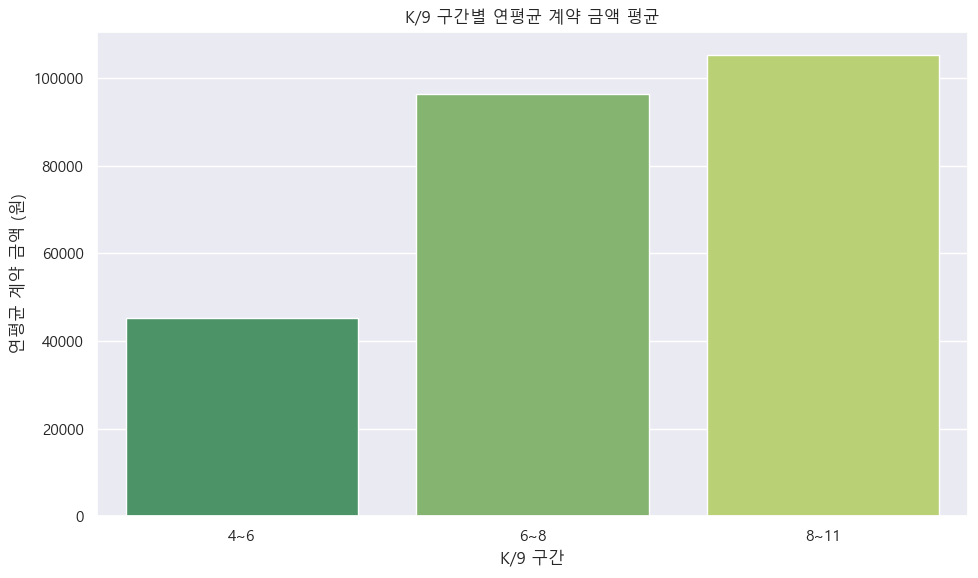

In [244]:
binned_barplot_custom(
    merged,
    x_col='K/9',
    bins = [4, 6, 8, 11],
    labels = ['4~6', '6~8', '8~11']
)

In [224]:
# 상관계수 계산
correlation = merged[['K/9', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 K/9와 계약 총액의 상관계수: {correlation:.3f}')

📌 K/9와 계약 총액의 상관계수: 0.241


## 추가3. BB/9

- 산점도

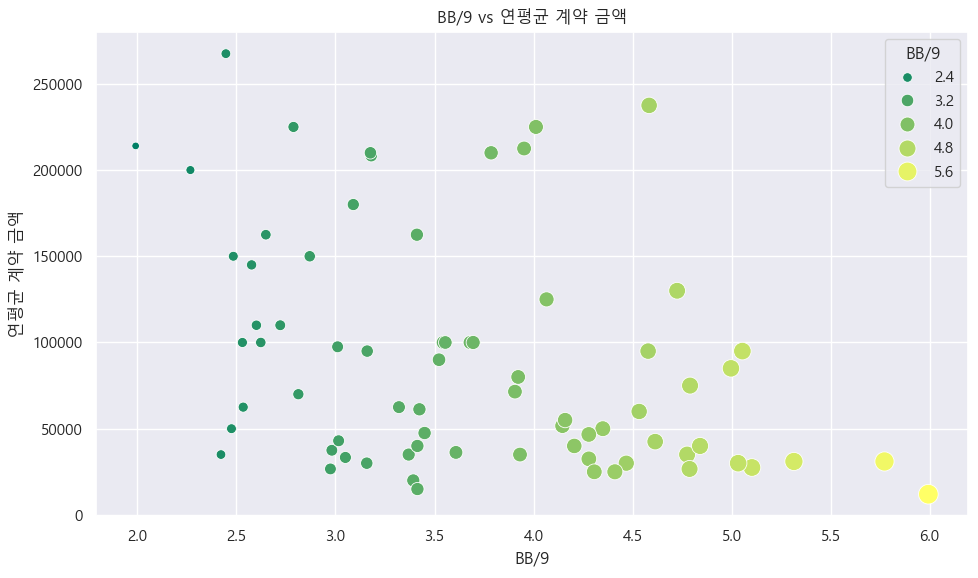

In [229]:
scatter_with_size(merged, 'BB/9')

- 막대

In [232]:
merged['BB/9'].min()

1.9909706546275396

In [236]:
merged['BB/9'].max()

5.993340732519423

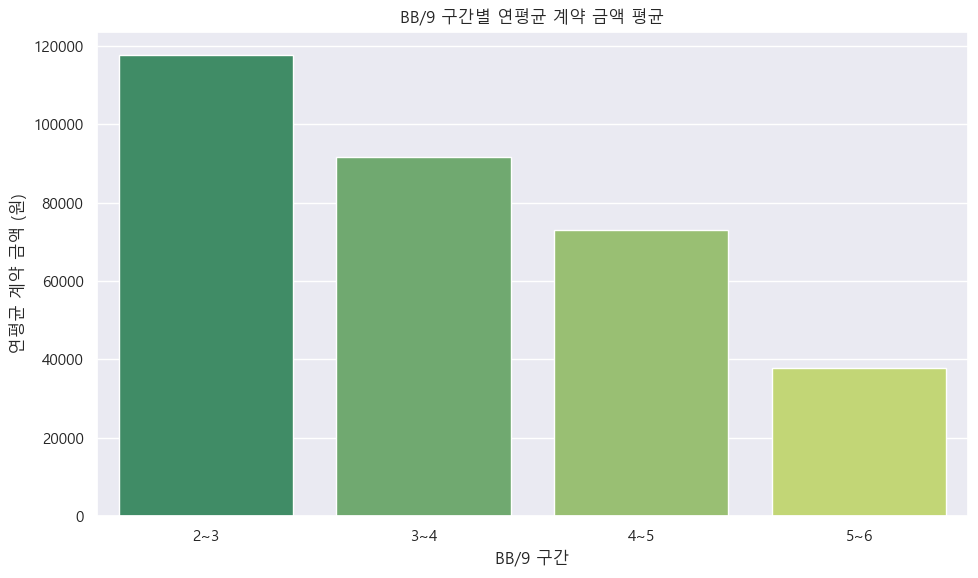

In [238]:
binned_barplot_custom(
    merged,
    x_col='BB/9',
    bins = [2, 3, 4, 5, 6],
    labels = ['2~3', '3~4', '4~5', '5~6']
)

In [240]:
# 상관계수 계산
correlation = merged[['BB/9', '연평균 계약 금액']].corr().iloc[0, 1]
print(f'📌 BB/9와 계약 총액의 상관계수: {correlation:.3f}')

📌 BB/9와 계약 총액의 상관계수: -0.383
